# Model to predict income segregation level of visitors
Baseline model: GBT regression.

In [1]:
%load_ext autoreload
%autoreload 2
%cd D:\mobi-social-segregation-se

D:\mobi-social-segregation-se


In [2]:
# Load libs
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import PCA
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [4]:
# Set up pyspark
#os.environ['PYSPARK_PYTHON'] = sys.executable
#os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
# Create new context
spark_conf = SparkConf().setMaster("local[18]").setAppName("MobiSeg")
spark_conf.set("spark.executor.heartbeatInterval","3600s")
spark_conf.set("spark.network.timeout","7200s")
spark_conf.set("spark.sql.files.ignoreCorruptFiles","true")
spark_conf.set("spark.driver.memory", "40g")
spark_conf.set("spark.executor.memory","8g")
spark_conf.set("spark.memory.fraction", "0.6")
spark_conf.set("spark.sql.session.timeZone", "UTC")
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
print('Web UI:', spark.sparkContext.uiWebUrl)

KeyboardInterrupt: 

## 1. Load data

In [23]:
df = spark.read.parquet("results/data4model_agg.parquet")
df.cache()
df.printSchema()

root
 |-- number_of_locations: double (nullable = true)
 |-- number_of_visits: double (nullable = true)
 |-- average_displacement: double (nullable = true)
 |-- radius_of_gyration: double (nullable = true)
 |-- median_distance_from_home: double (nullable = true)
 |-- Not Sweden: double (nullable = true)
 |-- Lowest income group: double (nullable = true)
 |-- car_ownership: double (nullable = true)
 |-- cum_jobs: double (nullable = true)
 |-- cum_stops: double (nullable = true)
 |-- num_jobs: double (nullable = true)
 |-- num_stops: double (nullable = true)
 |-- gsi: double (nullable = true)
 |-- length_density: double (nullable = true)
 |-- evenness_income: double (nullable = true)



In [48]:
splits = df.randomSplit([0.9, 0.1])
train_df = splits[0]
test_df = splits[1]

## 2. Gradient-boosted tree regression (baseline)
### 2.1 Model definition 1 - without PCA

In [49]:
vectorAssembler = VectorAssembler(inputCols=[
            'number_of_locations', 'number_of_visits', 'average_displacement', 'radius_of_gyration', 'median_distance_from_home',
            'Not Sweden', 'Lowest income group', 'car_ownership',
            'cum_jobs', 'cum_stops',
            'num_jobs', 'num_stops', 'gsi', 'length_density'],
                                  outputCol='features').setHandleInvalid("skip")
normalizer = Normalizer(inputCol='features', outputCol='features_norm', p=1.0)
gbt = GBTRegressor(featuresCol='features_norm', labelCol='evenness_income', maxIter=10)
pipline = Pipeline(stages=[vectorAssembler, normalizer, gbt])

Training

In [50]:
gbt_model = pipline.fit(train_df)

Evaluation - training data

In [52]:
preds_train = gbt_model.transform(train_df)
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="evenness_income", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(preds_train)
print("Root Mean Squared Error (RMSE) on train data = %g" % rmse)
df_preds_train = preds_train.select("prediction", "evenness_income").toPandas()

Root Mean Squared Error (RMSE) on train data = 0.0709844


Evaluation - test data

In [53]:
preds_test = gbt_model.transform(test_df)
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="evenness_income", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(preds_test)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
df_preds_test = preds_test.select("prediction", "evenness_income").toPandas()

Root Mean Squared Error (RMSE) on train data = 0.0740002


#### Visualise the results

In [54]:
df_preds_train.loc[:, 'label'] = 'train'
df_preds_test.loc[:, 'label'] = 'test'
df_preds = pd.concat([df_preds_train, df_preds_test])

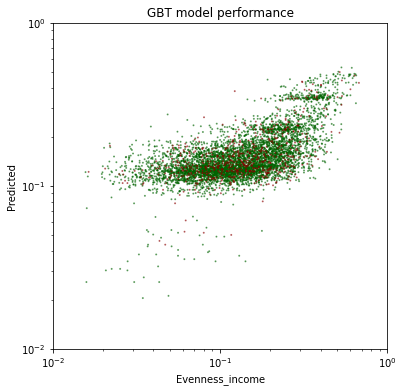

In [57]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(x=df_preds['evenness_income'], y=df_preds['prediction'], s=1,
            c=df_preds['label'].map({'train':'darkgreen','test':'darkred'}), alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlim(10**(-2), 1)
plt.ylim(10**(-2), 1)
plt.xlabel("Evenness_income")
plt.ylabel("Predicted")
plt.title('GBT model performance')
plt.show()

### 2.2 Model definition 2 - with PCA

In [58]:
vectorAssembler = VectorAssembler(inputCols=[
            'number_of_locations', 'number_of_visits', 'average_displacement', 'radius_of_gyration', 'median_distance_from_home',
            'Not Sweden', 'Lowest income group', 'car_ownership',
            'cum_jobs', 'cum_stops',
            'num_jobs', 'num_stops', 'gsi', 'length_density'],
                                  outputCol='features').setHandleInvalid("skip")
normalizer = Normalizer(inputCol='features', outputCol='features_norm', p=1.0)
pca = PCA(k=3, inputCol="features_norm", outputCol="pcaFeatures")
gbt = GBTRegressor(featuresCol='pcaFeatures', labelCol='evenness_income', maxIter=10)
pipline = Pipeline(stages=[vectorAssembler, normalizer, pca, gbt])

Training

In [59]:
gbt_model = pipline.fit(train_df)

Evaluation - training data

In [60]:
preds_train = gbt_model.transform(train_df)
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="evenness_income", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(preds_train)
print("Root Mean Squared Error (RMSE) on train data = %g" % rmse)
df_preds_train = preds_train.select("prediction", "evenness_income").toPandas()

Root Mean Squared Error (RMSE) on train data = 0.0946775


Evaluation - test data

In [61]:
preds_test = gbt_model.transform(test_df)
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="evenness_income", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(preds_test)
print("Root Mean Squared Error (RMSE) on train data = %g" % rmse)
df_preds_test = preds_test.select("prediction", "evenness_income").toPandas()

Root Mean Squared Error (RMSE) on train data = 0.096909


#### Visualise the results

In [62]:
df_preds_train.loc[:, 'label'] = 'train'
df_preds_test.loc[:, 'label'] = 'test'
df_preds = pd.concat([df_preds_train, df_preds_test])

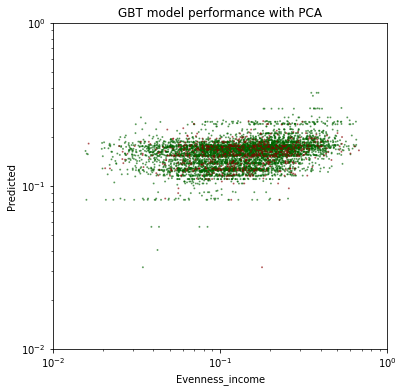

In [63]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(x=df_preds['evenness_income'], y=df_preds['prediction'], s=1,
            c=df_preds['label'].map({'train':'darkgreen','test':'darkred'}), alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlim(10**(-2), 1)
plt.ylim(10**(-2), 1)
plt.xlabel("Evenness_income")
plt.ylabel("Predicted")
plt.title('GBT model performance with PCA')
plt.show()